# In this notebook, I will introduce the concept and the implementation of Deutsch algorithm. It is an example to illustrate the quantum advantage in parallelism over the classical algorithm.


In [3]:
import qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute #(using BasicAer if Aer has import problem)
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.tools.visualization import plot_histogram
from qiskit import IBMQ


In [4]:
import numpy as np
from time import time
import random

## Problem Description
Given a black box (or equivalently called oracle), there are only two types of operation. The input is either $0$ or $1$, as well as the output. There are two types of operations in the black box, namely constant and balanced. What is the minimum number of shots for one to decode the black box?
In this problem, we want to know whether the operation is :    
1) Constant: the output is always $0$ or $1$, i.e. $f(0)\rightarrow 0, f(1) \rightarrow 1$ or $f(0)\rightarrow 1, f(1) \rightarrow 1$.     
2) Balanced: $f(0) \rightarrow 1, f(1) \rightarrow 0$,     
where $f$ is the operation in the black box. 

Classically, we need at least two queries to determine which operations it is. For example, given $f(0) \rightarrow 1$, one can not determine whether it's constant or balanced. One needs a second query, $f(1)$ for the final determination. 

In the Quantum world, we can utilize the superposition principle to do just one query and determine the oracle. In the following, I will show how this is done.

## The quantum oracle is based on two qubit operation.   

Because the operators in a quantum system must be unitary, we can not directly apply classical oracle operation to quantum systems. Instead, we will use $| q_1, q_2\rangle  \rightarrow |q_1, q_2 \bigoplus f(q_1) \rangle$, where $\bigoplus$ is addition modulo 2 and $f$ is either the balanced or the constant operation as descrived above. We first take a look at some resultant states of the qubit after some possible operations. To do that, we will need a method to determine the wave function. Because wave function is not a measurable quantity, we need to do a "translation" to convert the wave function to some measurable quantities that we can observe.

## Phase Kickback
We will introduce the ancilla (work) bit that helps to solve for the oracle.  
Instead of changing the qubit state, we will use phase kickback such that only the phase of the resultant wave function is changed, while the ancilla bit is unchanged. By applying Hadamard gate, we show that the final qubit state is 0 if the function is constant, while 1 if the function is balanced.

## How to read out the wave function   
The state of a qubit is described by its wave function. The absolute square of the wave function gives the probability of the qubit being in the computational basis state. In quamtum circuit, the measurement only gives the probability. We can use the Aer.get_backend('statevector_simulator') to get the wave function. Below shows an example by creating a superposition  $| 0\rangle - |1\rangle.$ In qiskit, the wave function is written in the basis of $(1,0)$, and $(0,1).$, like spin up and spin down. However, on real qubit, it is not possible to read out the statevector which violates the principle of quantum mechanics.

In [12]:
q=QuantumRegister(1)
cir=QuantumCircuit(q)
cir.x(q[0])
cir.h(q[0])
backend = Aer.get_backend('statevector_simulator')
result = qiskit.execute(cir, backend=backend).result()
result.get_statevector()

array([ 0.70710678+0.j, -0.70710678+0.j])

Below is another example of obtaining the wave function of two qubits. The product state after gate operations is $\frac{1}{({2})}(1, -1)_1^T \bigotimes  (1,1)_0^T = \frac{1}{({2})} (1,1,-1,-1)^T$. (Note that in qiskit, the first qubits goes to the RHS.)

In [14]:
q=QuantumRegister(2)
cir=QuantumCircuit(q)
cir.h(q[0])
cir.x(q[1])
cir.h(q[1])
backend = Aer.get_backend('statevector_simulator')
result = qiskit.execute(cir, backend=backend).result()
result.get_statevector()

array([ 0.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j])

### The oracle function for two qubits:
To build the oracle, we first write down the matrix representation of the oracle operations in the two-bit basis, i.e. $|00\rangle,|01\rangle. |10\rangle, |11\rangle$. The derivation is straightforward can can be referenced in p. 57-59 in 1903.04359.

In [18]:
def oracle_2bits(randum, cir):
    # case1: f(0,1) -> 0, constant
    if randnum%4==0:
        cir.iden(q)
    #case 2: f(0,1) -> (0,1), balanced
    if randnum%4==1:
        cir.cx(q[0],q[1])
    #case3: f(0,1) -> 1, constant
    if randnum%4==2:
        cir.x(q[1])
    #case4: f(0,1) -> (1,0), balanced
    if randnum%4==3:
        # reverse cnot
        cir.x(q[0])
        cir.cx(q[0],q[1])
        # put qubit 0 back to its initial state
        cir.x(q[0]) 
    return cir

### The query function:

In [62]:
q=QuantumRegister(2,'q')
c=ClassicalRegister(2,'c')
cir=QuantumCircuit(q,c)
# Preparation of the state
cir.h(q[0])
cir.x(q[1])
cir.h(q[1])

# call oracle
#random.seed(6)
randnum=random.randint(0,100)
cir=oracle_2bits(randnum,cir)
# trick: turn q0 back to 0 or 1 state \
# turn q1 to its beginning state
cir.h(q[0])
cir.h(q[1])
# apply measurement
cir.measure(q,c)


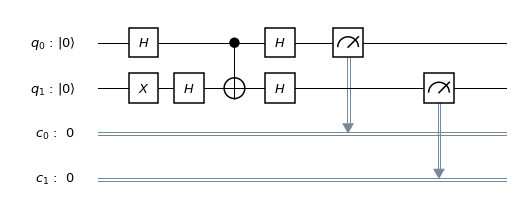

In [63]:
# Let's take a look at the circuit that I just created. 
cir.draw(output='mpl')

In [64]:
result=qiskit.execute(cir, Aer.get_backend('qasm_simulator'), shots=1024).result()
print(result.get_counts())
resultstr=list(result.get_counts().keys())
print("The state of the first qubit, i.e. the RHS bit is {}.".format(resultstr[0][-1]))
# if c[0] is 0, that means the oracle is constant, i.e. f(0)=f(1)
# if c[0] is 1, that means the oracle is balanced, i.e. f(0) not equal to f(1)
print("The randnum is {}, mod 4 ={}. If mod 4 ==0 or 2, the oracle is constant, if mod 4== 1 or 3, the oracle is balanced.".format(randnum, randnum%4))
if randnum%4==0 or randnum %4 ==2:
    print('Given the randum, the oracle is constant')
if randnum%4==1 or randnum %4 ==3:
    print('Given the randum, the oracle is balanced')
if list(result.get_counts().keys())[0] =='11':
    print('The query tells us that the blackbox is balanced.')
if list(result.get_counts().keys())[0]=='10':
    print('The query tells us that the balckbox is constant.')

{'11': 1024}
The state of the first qubit, i.e. the RHS bit is 1.
The randnum is 93, mod 4 =1. If mod 4 ==0 or 2, the oracle is constant, if mod 4== 1 or 3, the oracle is balanced.
Given the randum, the oracle is balanced
The query tells us that the blackbox is balanced.


## Discussion
Voila! The blackbox is solved in just ONE query. This is because we use the superposition of the computational basis. Despite its simplicity, this example shows the advantage of using the principle quantum mechanics in computation.   